In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

card_df = pd.read_csv('./creditcard.csv')
card_df.head(3)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0


In [2]:
card_df['Class'].value_counts()

0    284315
1       492
Name: Class, dtype: int64

## 데이터의 비대칭 해결

<AxesSubplot:xlabel='Amount'>

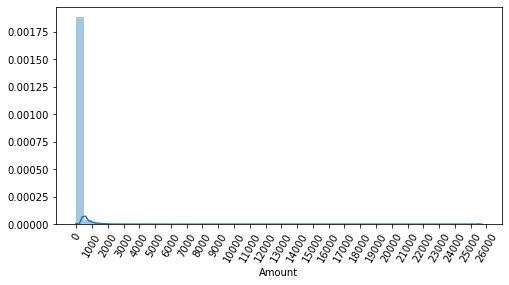

In [3]:
import seaborn as sns

plt.figure(figsize=(8, 4))
plt.xticks(range(0, 30000, 1000), rotation=60)
sns.distplot(card_df['Amount'])

In [4]:
from sklearn.preprocessing import StandardScaler
# 사이킷런의 StandardScaler를 이용하여 정규분포 형태로 Amount 피처값 변환하는 로직으로 수정. 

In [5]:
scaler = StandardScaler()
amount_n = scaler.fit_transform(card_df['Amount'].values.reshape(-1,1))
card_df.insert(0, 'Amount_Scaled', amount_n)
card_df.drop('Amount', axis=1, inplace=True)

## train

In [6]:
from sklearn.model_selection import train_test_split

# 인자로 입력받은 DataFrame을 복사 한 뒤 Time 컬럼만 삭제하고 복사된 DataFrame 반환
def get_preprocessed_df(df=None):
    df_copy = df.copy()
    df_copy.drop('Time', axis=1, inplace=True)
    return df_copy

In [7]:
# 사전 데이터 가공 후 학습과 테스트 데이터 세트를 반환하는 함수.
def get_train_test_dataset(df=None):
    # 인자로 입력된 DataFrame의 사전 데이터 가공이 완료된 복사 DataFrame 반환
    df_copy = get_preprocessed_df(df)
    # DataFrame의 맨 마지막 컬럼이 레이블, 나머지는 피처들
    X_features = df_copy.iloc[:, :-1]
    y_target = df_copy.iloc[:, -1]
    # train_test_split( )으로 학습과 테스트 데이터 분할. stratify=y_target으로 Stratified 기반 분할
    X_train, X_test, y_train, y_test = \
    train_test_split(X_features, y_target, test_size=0.3, random_state=0, stratify=y_target)
    # 학습과 테스트 데이터 세트 반환
    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = get_train_test_dataset(card_df)

In [8]:
print('학습 데이터 레이블 값 비율')
print(y_train.value_counts()/y_train.shape[0] * 100)
print('테스트 데이터 레이블 값 비율')
print(y_test.value_counts()/y_test.shape[0] * 100)

학습 데이터 레이블 값 비율
0    99.827451
1     0.172549
Name: Class, dtype: float64
테스트 데이터 레이블 값 비율
0    99.826785
1     0.173215
Name: Class, dtype: float64


### Xgboost

In [9]:
import xgboost as xgb
from xgboost import plot_importance

from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import f1_score, roc_auc_score

def get_clf_eval(y_test , pred):
    confusion = confusion_matrix( y_test, pred)
    accuracy = accuracy_score(y_test , pred)
    precision = precision_score(y_test , pred)
    recall = recall_score(y_test , pred)
    f1 = f1_score(y_test,pred)
    roc_auc = roc_auc_score(y_test, pred)
    print('오차 행렬')
    print(confusion)
    print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f},\
    F1: {3:.4f}, AUC:{4:.4f}'.format(accuracy, precision, recall, f1, roc_auc))

In [10]:
from xgboost import XGBClassifier

xgb_wrapper = XGBClassifier(n_estimators=400, learning_rate=0.1, max_depth=3)
evals = [(X_test, y_test)]
xgb_wrapper.fit(X_train, y_train, early_stopping_rounds=100, eval_metric="logloss", 
                eval_set=evals, verbose=True)
ws100_preds = xgb_wrapper.predict(X_test)

[0]	validation_0-logloss:0.59836
[1]	validation_0-logloss:0.52081
[2]	validation_0-logloss:0.45608
[3]	validation_0-logloss:0.40137
[4]	validation_0-logloss:0.35468
[5]	validation_0-logloss:0.31444
[6]	validation_0-logloss:0.27953
[7]	validation_0-logloss:0.24911
[8]	validation_0-logloss:0.22245
[9]	validation_0-logloss:0.19898
[10]	validation_0-logloss:0.17829
[11]	validation_0-logloss:0.15995
[12]	validation_0-logloss:0.14370
[13]	validation_0-logloss:0.12921
[14]	validation_0-logloss:0.11629
[15]	validation_0-logloss:0.10478
[16]	validation_0-logloss:0.09449
[17]	validation_0-logloss:0.08528
[18]	validation_0-logloss:0.07702
[19]	validation_0-logloss:0.06963
[20]	validation_0-logloss:0.06299
[21]	validation_0-logloss:0.05703
[22]	validation_0-logloss:0.05166
[23]	validation_0-logloss:0.04685
[24]	validation_0-logloss:0.04251
[25]	validation_0-logloss:0.03860
[26]	validation_0-logloss:0.03508
[27]	validation_0-logloss:0.03193
[28]	validation_0-logloss:0.02907
[29]	validation_0-loglos

[238]	validation_0-logloss:0.00279
[239]	validation_0-logloss:0.00279
[240]	validation_0-logloss:0.00278
[241]	validation_0-logloss:0.00278
[242]	validation_0-logloss:0.00279
[243]	validation_0-logloss:0.00278
[244]	validation_0-logloss:0.00279
[245]	validation_0-logloss:0.00279
[246]	validation_0-logloss:0.00279
[247]	validation_0-logloss:0.00279
[248]	validation_0-logloss:0.00279
[249]	validation_0-logloss:0.00279
[250]	validation_0-logloss:0.00278
[251]	validation_0-logloss:0.00279
[252]	validation_0-logloss:0.00279
[253]	validation_0-logloss:0.00279
[254]	validation_0-logloss:0.00279
[255]	validation_0-logloss:0.00279
[256]	validation_0-logloss:0.00279
[257]	validation_0-logloss:0.00279
[258]	validation_0-logloss:0.00278
[259]	validation_0-logloss:0.00279
[260]	validation_0-logloss:0.00279
[261]	validation_0-logloss:0.00278
[262]	validation_0-logloss:0.00279
[263]	validation_0-logloss:0.00279
[264]	validation_0-logloss:0.00279
[265]	validation_0-logloss:0.00279
[266]	validation_0-l

In [11]:
get_clf_eval(y_test , ws100_preds)

오차 행렬
[[85289     6]
 [   41   107]]
정확도: 0.9994, 정밀도: 0.9469, 재현율: 0.7230,    F1: 0.8199, AUC:0.8615


### LightGBM

In [12]:
from lightgbm import LGBMClassifier

lgbm_wrapper = LGBMClassifier(n_estimators=400, boost_from_average = True)

evals = [(X_test, y_test)]
lgbm_wrapper.fit(X_train, y_train, early_stopping_rounds=100, eval_metric="logloss", 
                 eval_set=evals, verbose=True)
preds = lgbm_wrapper.predict(X_test)

[1]	valid_0's binary_logloss: 0.0130349
Training until validation scores don't improve for 100 rounds
[2]	valid_0's binary_logloss: 0.0445173
[3]	valid_0's binary_logloss: 0.0276997
[4]	valid_0's binary_logloss: 0.0226812
[5]	valid_0's binary_logloss: 0.0219814
[6]	valid_0's binary_logloss: 0.0220822
[7]	valid_0's binary_logloss: 0.0274095
[8]	valid_0's binary_logloss: 0.0255324
[9]	valid_0's binary_logloss: 0.0287182
[10]	valid_0's binary_logloss: 0.0248801
[11]	valid_0's binary_logloss: 0.0230327
[12]	valid_0's binary_logloss: 0.0245406
[13]	valid_0's binary_logloss: 0.027904
[14]	valid_0's binary_logloss: 0.0273035
[15]	valid_0's binary_logloss: 0.0288502
[16]	valid_0's binary_logloss: 0.0297051
[17]	valid_0's binary_logloss: 0.0298256
[18]	valid_0's binary_logloss: 0.0306686
[19]	valid_0's binary_logloss: 0.0341406
[20]	valid_0's binary_logloss: 0.0307677
[21]	valid_0's binary_logloss: 0.0299825
[22]	valid_0's binary_logloss: 0.0311036
[23]	valid_0's binary_logloss: 0.0337596
[24]	

In [13]:
get_clf_eval(y_test, preds)

오차 행렬
[[85227    68]
 [   33   115]]
정확도: 0.9988, 정밀도: 0.6284, 재현율: 0.7770,    F1: 0.6949, AUC:0.8881


### 하이퍼파라미터 튜닝

In [14]:
from sklearn.model_selection import GridSearchCV

# 하이퍼 파라미터 테스트의 수행 속도를 향상시키기 위해 n_estimators를 100으로 감소
xgb_clf = XGBClassifier(n_estimators=100)

params = {'max_depth':[5, 7] , 'min_child_weight':[1,3] ,'colsample_bytree':[0.5, 0.75] }

gridcv = GridSearchCV(xgb_clf, param_grid=params, cv=3)
gridcv.fit(X_train, y_train, early_stopping_rounds=30, eval_metric="auc",
           eval_set=[(X_train, y_train), (X_test, y_test)])

print('GridSearchCV 최적 파라미터:',gridcv.best_params_) 

xgb_roc_score = roc_auc_score(y_test, gridcv.predict_proba(X_test)[:,1], average='macro')
print('ROC AUC: {0:.4f}'.format(xgb_roc_score))

[0]	validation_0-auc:0.82951	validation_1-auc:0.79341
[1]	validation_0-auc:0.86916	validation_1-auc:0.83422
[2]	validation_0-auc:0.92721	validation_1-auc:0.89631
[3]	validation_0-auc:0.93165	validation_1-auc:0.90678
[4]	validation_0-auc:0.93166	validation_1-auc:0.90681
[5]	validation_0-auc:0.93167	validation_1-auc:0.90681
[6]	validation_0-auc:0.93314	validation_1-auc:0.91025
[7]	validation_0-auc:0.93306	validation_1-auc:0.91015
[8]	validation_0-auc:0.93305	validation_1-auc:0.91007
[9]	validation_0-auc:0.93290	validation_1-auc:0.90988
[10]	validation_0-auc:0.93663	validation_1-auc:0.91241
[11]	validation_0-auc:0.93813	validation_1-auc:0.91233
[12]	validation_0-auc:0.93821	validation_1-auc:0.91238
[13]	validation_0-auc:0.95280	validation_1-auc:0.92715
[14]	validation_0-auc:0.95677	validation_1-auc:0.92988
[15]	validation_0-auc:0.96090	validation_1-auc:0.93599
[16]	validation_0-auc:0.97705	validation_1-auc:0.95955
[17]	validation_0-auc:0.97809	validation_1-auc:0.95894
[18]	validation_0-au

[29]	validation_0-auc:0.99568	validation_1-auc:0.97982
[30]	validation_0-auc:0.99527	validation_1-auc:0.98036
[31]	validation_0-auc:0.99537	validation_1-auc:0.98011
[32]	validation_0-auc:0.99521	validation_1-auc:0.98054
[33]	validation_0-auc:0.99576	validation_1-auc:0.98154
[34]	validation_0-auc:0.99542	validation_1-auc:0.97942
[35]	validation_0-auc:0.99519	validation_1-auc:0.98004
[36]	validation_0-auc:0.99514	validation_1-auc:0.97837
[37]	validation_0-auc:0.99525	validation_1-auc:0.97849
[38]	validation_0-auc:0.99513	validation_1-auc:0.97895
[39]	validation_0-auc:0.99492	validation_1-auc:0.97922
[40]	validation_0-auc:0.99431	validation_1-auc:0.97914
[41]	validation_0-auc:0.99395	validation_1-auc:0.97814
[42]	validation_0-auc:0.99413	validation_1-auc:0.97738
[43]	validation_0-auc:0.99413	validation_1-auc:0.97636
[44]	validation_0-auc:0.99429	validation_1-auc:0.97661
[45]	validation_0-auc:0.99429	validation_1-auc:0.97630
[46]	validation_0-auc:0.99408	validation_1-auc:0.97566
[47]	valid

[53]	validation_0-auc:0.98599	validation_1-auc:0.97120
[0]	validation_0-auc:0.83382	validation_1-auc:0.79334
[1]	validation_0-auc:0.87204	validation_1-auc:0.83412
[2]	validation_0-auc:0.91538	validation_1-auc:0.86547
[3]	validation_0-auc:0.93316	validation_1-auc:0.90676
[4]	validation_0-auc:0.93313	validation_1-auc:0.91027
[5]	validation_0-auc:0.93313	validation_1-auc:0.91029
[6]	validation_0-auc:0.93312	validation_1-auc:0.91027
[7]	validation_0-auc:0.93312	validation_1-auc:0.91027
[8]	validation_0-auc:0.93601	validation_1-auc:0.91017
[9]	validation_0-auc:0.93857	validation_1-auc:0.91298
[10]	validation_0-auc:0.93858	validation_1-auc:0.91305
[11]	validation_0-auc:0.95886	validation_1-auc:0.94311
[12]	validation_0-auc:0.96308	validation_1-auc:0.94594
[13]	validation_0-auc:0.97035	validation_1-auc:0.95419
[14]	validation_0-auc:0.97080	validation_1-auc:0.95962
[15]	validation_0-auc:0.97479	validation_1-auc:0.96267
[16]	validation_0-auc:0.97695	validation_1-auc:0.96388
[17]	validation_0-au

[84]	validation_0-auc:0.99336	validation_1-auc:0.98458
[85]	validation_0-auc:0.99325	validation_1-auc:0.98457
[86]	validation_0-auc:0.99318	validation_1-auc:0.98429
[87]	validation_0-auc:0.99329	validation_1-auc:0.98459
[88]	validation_0-auc:0.99335	validation_1-auc:0.98470
[89]	validation_0-auc:0.99339	validation_1-auc:0.98461
[90]	validation_0-auc:0.99350	validation_1-auc:0.98471
[91]	validation_0-auc:0.99348	validation_1-auc:0.98489
[92]	validation_0-auc:0.99360	validation_1-auc:0.98469
[0]	validation_0-auc:0.83384	validation_1-auc:0.79333
[1]	validation_0-auc:0.87328	validation_1-auc:0.83375
[2]	validation_0-auc:0.91530	validation_1-auc:0.88948
[3]	validation_0-auc:0.93306	validation_1-auc:0.91018
[4]	validation_0-auc:0.93306	validation_1-auc:0.91019
[5]	validation_0-auc:0.93303	validation_1-auc:0.91017
[6]	validation_0-auc:0.93302	validation_1-auc:0.91015
[7]	validation_0-auc:0.93442	validation_1-auc:0.91009
[8]	validation_0-auc:0.95779	validation_1-auc:0.94102
[9]	validation_0-au

[85]	validation_0-auc:0.99156	validation_1-auc:0.98125
[86]	validation_0-auc:0.99176	validation_1-auc:0.98150
[87]	validation_0-auc:0.99180	validation_1-auc:0.98130
[88]	validation_0-auc:0.99180	validation_1-auc:0.98119
[89]	validation_0-auc:0.99179	validation_1-auc:0.98141
[90]	validation_0-auc:0.99169	validation_1-auc:0.98105
[91]	validation_0-auc:0.99155	validation_1-auc:0.98078
[92]	validation_0-auc:0.99159	validation_1-auc:0.98107
[93]	validation_0-auc:0.99153	validation_1-auc:0.98114
[94]	validation_0-auc:0.99169	validation_1-auc:0.98120
[95]	validation_0-auc:0.99164	validation_1-auc:0.98159
[96]	validation_0-auc:0.99175	validation_1-auc:0.98173
[97]	validation_0-auc:0.99191	validation_1-auc:0.98201
[98]	validation_0-auc:0.99195	validation_1-auc:0.98218
[99]	validation_0-auc:0.99211	validation_1-auc:0.98206
[0]	validation_0-auc:0.82951	validation_1-auc:0.79339
[1]	validation_0-auc:0.86484	validation_1-auc:0.83419
[2]	validation_0-auc:0.92724	validation_1-auc:0.89616
[3]	validatio

[9]	validation_0-auc:0.93856	validation_1-auc:0.91296
[10]	validation_0-auc:0.96149	validation_1-auc:0.94288
[11]	validation_0-auc:0.96765	validation_1-auc:0.95304
[12]	validation_0-auc:0.97040	validation_1-auc:0.95246
[13]	validation_0-auc:0.97352	validation_1-auc:0.95768
[14]	validation_0-auc:0.97313	validation_1-auc:0.95825
[15]	validation_0-auc:0.97430	validation_1-auc:0.95807
[16]	validation_0-auc:0.97667	validation_1-auc:0.95885
[17]	validation_0-auc:0.98023	validation_1-auc:0.96228
[18]	validation_0-auc:0.98014	validation_1-auc:0.96356
[19]	validation_0-auc:0.98725	validation_1-auc:0.97760
[20]	validation_0-auc:0.98909	validation_1-auc:0.97950
[21]	validation_0-auc:0.99143	validation_1-auc:0.97956
[22]	validation_0-auc:0.99104	validation_1-auc:0.98227
[23]	validation_0-auc:0.99211	validation_1-auc:0.98407
[24]	validation_0-auc:0.99323	validation_1-auc:0.98399
[25]	validation_0-auc:0.99350	validation_1-auc:0.98234
[26]	validation_0-auc:0.99316	validation_1-auc:0.98232
[27]	valida

[15]	validation_0-auc:0.97144	validation_1-auc:0.95126
[16]	validation_0-auc:0.97787	validation_1-auc:0.95283
[17]	validation_0-auc:0.97775	validation_1-auc:0.95451
[18]	validation_0-auc:0.97764	validation_1-auc:0.95561
[19]	validation_0-auc:0.97881	validation_1-auc:0.96103
[20]	validation_0-auc:0.98007	validation_1-auc:0.96083
[21]	validation_0-auc:0.98027	validation_1-auc:0.96231
[22]	validation_0-auc:0.98329	validation_1-auc:0.95976
[23]	validation_0-auc:0.98647	validation_1-auc:0.96457
[24]	validation_0-auc:0.98766	validation_1-auc:0.97327
[25]	validation_0-auc:0.98914	validation_1-auc:0.97229
[26]	validation_0-auc:0.98943	validation_1-auc:0.97103
[27]	validation_0-auc:0.98967	validation_1-auc:0.97021
[28]	validation_0-auc:0.98924	validation_1-auc:0.96861
[29]	validation_0-auc:0.99016	validation_1-auc:0.96763
[30]	validation_0-auc:0.99051	validation_1-auc:0.96550
[31]	validation_0-auc:0.98998	validation_1-auc:0.96408
[32]	validation_0-auc:0.98928	validation_1-auc:0.96120
[33]	valid

[50]	validation_0-auc:0.99337	validation_1-auc:0.98029
[51]	validation_0-auc:0.99330	validation_1-auc:0.98039
[52]	validation_0-auc:0.99350	validation_1-auc:0.98125
[53]	validation_0-auc:0.99311	validation_1-auc:0.98139
[54]	validation_0-auc:0.99345	validation_1-auc:0.98139
[55]	validation_0-auc:0.99321	validation_1-auc:0.98103
[56]	validation_0-auc:0.99322	validation_1-auc:0.98156
[57]	validation_0-auc:0.99350	validation_1-auc:0.98172
[58]	validation_0-auc:0.99321	validation_1-auc:0.98147
[59]	validation_0-auc:0.99322	validation_1-auc:0.98097
[60]	validation_0-auc:0.99300	validation_1-auc:0.98050
[61]	validation_0-auc:0.99308	validation_1-auc:0.97986
[62]	validation_0-auc:0.99296	validation_1-auc:0.97920
[63]	validation_0-auc:0.99281	validation_1-auc:0.97962
[64]	validation_0-auc:0.99302	validation_1-auc:0.97991
[65]	validation_0-auc:0.99298	validation_1-auc:0.97950
[66]	validation_0-auc:0.99304	validation_1-auc:0.97964
[0]	validation_0-auc:0.89955	validation_1-auc:0.87139
[1]	validat

[55]	validation_0-auc:0.99503	validation_1-auc:0.97697
[56]	validation_0-auc:0.99501	validation_1-auc:0.97718
[57]	validation_0-auc:0.99492	validation_1-auc:0.97681
[58]	validation_0-auc:0.99485	validation_1-auc:0.97684
[59]	validation_0-auc:0.99509	validation_1-auc:0.97640
[0]	validation_0-auc:0.89522	validation_1-auc:0.87141
[1]	validation_0-auc:0.90245	validation_1-auc:0.88150
[2]	validation_0-auc:0.92573	validation_1-auc:0.90857
[3]	validation_0-auc:0.92572	validation_1-auc:0.90856
[4]	validation_0-auc:0.92717	validation_1-auc:0.90855
[5]	validation_0-auc:0.93286	validation_1-auc:0.90832
[6]	validation_0-auc:0.93282	validation_1-auc:0.91165
[7]	validation_0-auc:0.93424	validation_1-auc:0.91155
[8]	validation_0-auc:0.93556	validation_1-auc:0.91134
[9]	validation_0-auc:0.93550	validation_1-auc:0.91125
[10]	validation_0-auc:0.95295	validation_1-auc:0.92916
[11]	validation_0-auc:0.95295	validation_1-auc:0.92919
[12]	validation_0-auc:0.95701	validation_1-auc:0.93503
[13]	validation_0-au

[11]	validation_0-auc:0.95902	validation_1-auc:0.92917
[12]	validation_0-auc:0.96326	validation_1-auc:0.92884
[13]	validation_0-auc:0.96473	validation_1-auc:0.92869
[14]	validation_0-auc:0.96472	validation_1-auc:0.92861
[15]	validation_0-auc:0.96688	validation_1-auc:0.95302
[16]	validation_0-auc:0.97949	validation_1-auc:0.95892
[17]	validation_0-auc:0.98167	validation_1-auc:0.95791
[18]	validation_0-auc:0.98569	validation_1-auc:0.96729
[19]	validation_0-auc:0.98756	validation_1-auc:0.97116
[20]	validation_0-auc:0.98918	validation_1-auc:0.97208
[21]	validation_0-auc:0.98931	validation_1-auc:0.97096
[22]	validation_0-auc:0.99144	validation_1-auc:0.97150
[23]	validation_0-auc:0.99308	validation_1-auc:0.97359
[24]	validation_0-auc:0.99277	validation_1-auc:0.97747
[25]	validation_0-auc:0.99257	validation_1-auc:0.97667
[26]	validation_0-auc:0.99256	validation_1-auc:0.97763
[27]	validation_0-auc:0.99249	validation_1-auc:0.97720
[28]	validation_0-auc:0.99255	validation_1-auc:0.97898
[29]	valid

[2]	validation_0-auc:0.92714	validation_1-auc:0.90852
[3]	validation_0-auc:0.92710	validation_1-auc:0.91185
[4]	validation_0-auc:0.92709	validation_1-auc:0.91185
[5]	validation_0-auc:0.92704	validation_1-auc:0.91176
[6]	validation_0-auc:0.92705	validation_1-auc:0.91177
[7]	validation_0-auc:0.93132	validation_1-auc:0.91165
[8]	validation_0-auc:0.93124	validation_1-auc:0.91152
[9]	validation_0-auc:0.95686	validation_1-auc:0.94336
[10]	validation_0-auc:0.96103	validation_1-auc:0.94562
[11]	validation_0-auc:0.96113	validation_1-auc:0.94603
[12]	validation_0-auc:0.96719	validation_1-auc:0.94985
[13]	validation_0-auc:0.97417	validation_1-auc:0.95233
[14]	validation_0-auc:0.97524	validation_1-auc:0.95132
[15]	validation_0-auc:0.97478	validation_1-auc:0.95391
[16]	validation_0-auc:0.97734	validation_1-auc:0.95581
[17]	validation_0-auc:0.97770	validation_1-auc:0.95637
[18]	validation_0-auc:0.97759	validation_1-auc:0.95670
[19]	validation_0-auc:0.98154	validation_1-auc:0.96164
[20]	validation_0-

[19]	validation_0-auc:0.98540	validation_1-auc:0.97053
[20]	validation_0-auc:0.99388	validation_1-auc:0.97402
[21]	validation_0-auc:0.99632	validation_1-auc:0.97495
[22]	validation_0-auc:0.99620	validation_1-auc:0.97821
[23]	validation_0-auc:0.99834	validation_1-auc:0.98221
[24]	validation_0-auc:0.99885	validation_1-auc:0.98273
[25]	validation_0-auc:0.99894	validation_1-auc:0.98225
[26]	validation_0-auc:0.99946	validation_1-auc:0.98222
[27]	validation_0-auc:0.99967	validation_1-auc:0.98474
[28]	validation_0-auc:0.99982	validation_1-auc:0.98362
[29]	validation_0-auc:0.99991	validation_1-auc:0.98331
[30]	validation_0-auc:0.99995	validation_1-auc:0.98369
[31]	validation_0-auc:0.99998	validation_1-auc:0.98390
[32]	validation_0-auc:0.99998	validation_1-auc:0.98288
[33]	validation_0-auc:0.99999	validation_1-auc:0.98171
[34]	validation_0-auc:0.99999	validation_1-auc:0.98006
[35]	validation_0-auc:1.00000	validation_1-auc:0.98029
[36]	validation_0-auc:1.00000	validation_1-auc:0.98028
[37]	valid

In [15]:
xgb_clf = XGBClassifier(n_estimators=1000, colsample_bytree = 0.5, max_depth = 7, min_child_weight = 1, \
                       learning_rate = 0.02, reg_alpha=0.03)

xgb_clf.fit(X_train, y_train, early_stopping_rounds=200, eval_metric="auc",
           eval_set=[(X_train, y_train), (X_test, y_test)])

xgb_roc_score = roc_auc_score(y_test, xgb_clf.predict_proba(X_test)[:,1], average='macro')
print('ROC AUC: {0:.4f}'.format(xgb_roc_score))

[0]	validation_0-auc:0.83530	validation_1-auc:0.79333
[1]	validation_0-auc:0.87360	validation_1-auc:0.83415
[2]	validation_0-auc:0.91246	validation_1-auc:0.86552
[3]	validation_0-auc:0.93320	validation_1-auc:0.90673
[4]	validation_0-auc:0.93320	validation_1-auc:0.90689
[5]	validation_0-auc:0.93320	validation_1-auc:0.90691
[6]	validation_0-auc:0.93317	validation_1-auc:0.90688
[7]	validation_0-auc:0.93317	validation_1-auc:0.90688
[8]	validation_0-auc:0.93314	validation_1-auc:0.90684
[9]	validation_0-auc:0.93314	validation_1-auc:0.90684
[10]	validation_0-auc:0.93314	validation_1-auc:0.90683
[11]	validation_0-auc:0.93314	validation_1-auc:0.90684
[12]	validation_0-auc:0.93313	validation_1-auc:0.90684
[13]	validation_0-auc:0.93313	validation_1-auc:0.90685
[14]	validation_0-auc:0.93313	validation_1-auc:0.90685
[15]	validation_0-auc:0.93313	validation_1-auc:0.90685
[16]	validation_0-auc:0.93442	validation_1-auc:0.90667
[17]	validation_0-auc:0.93442	validation_1-auc:0.90661
[18]	validation_0-au

[149]	validation_0-auc:0.97269	validation_1-auc:0.95237
[150]	validation_0-auc:0.97269	validation_1-auc:0.95242
[151]	validation_0-auc:0.97268	validation_1-auc:0.95240
[152]	validation_0-auc:0.97266	validation_1-auc:0.95232
[153]	validation_0-auc:0.97267	validation_1-auc:0.95237
[154]	validation_0-auc:0.97266	validation_1-auc:0.95236
[155]	validation_0-auc:0.97266	validation_1-auc:0.95235
[156]	validation_0-auc:0.97271	validation_1-auc:0.95254
[157]	validation_0-auc:0.97271	validation_1-auc:0.95253
[158]	validation_0-auc:0.97267	validation_1-auc:0.95252
[159]	validation_0-auc:0.97273	validation_1-auc:0.95263
[160]	validation_0-auc:0.97273	validation_1-auc:0.95262
[161]	validation_0-auc:0.97273	validation_1-auc:0.95261
[162]	validation_0-auc:0.97269	validation_1-auc:0.95262
[163]	validation_0-auc:0.97277	validation_1-auc:0.95271
[164]	validation_0-auc:0.97276	validation_1-auc:0.95269
[165]	validation_0-auc:0.97274	validation_1-auc:0.95269
[166]	validation_0-auc:0.97299	validation_1-auc:

[296]	validation_0-auc:0.99410	validation_1-auc:0.97377
[297]	validation_0-auc:0.99407	validation_1-auc:0.97367
[298]	validation_0-auc:0.99404	validation_1-auc:0.97353
[299]	validation_0-auc:0.99412	validation_1-auc:0.97367
[300]	validation_0-auc:0.99409	validation_1-auc:0.97413
[301]	validation_0-auc:0.99419	validation_1-auc:0.97407
[302]	validation_0-auc:0.99420	validation_1-auc:0.97542
[303]	validation_0-auc:0.99417	validation_1-auc:0.97533
[304]	validation_0-auc:0.99419	validation_1-auc:0.97529
[305]	validation_0-auc:0.99424	validation_1-auc:0.97508
[306]	validation_0-auc:0.99424	validation_1-auc:0.97854
[307]	validation_0-auc:0.99421	validation_1-auc:0.97888
[308]	validation_0-auc:0.99417	validation_1-auc:0.97877
[309]	validation_0-auc:0.99418	validation_1-auc:0.97844
[310]	validation_0-auc:0.99417	validation_1-auc:0.97828
[311]	validation_0-auc:0.99420	validation_1-auc:0.97826
[312]	validation_0-auc:0.99445	validation_1-auc:0.97851
[313]	validation_0-auc:0.99461	validation_1-auc:

[443]	validation_0-auc:0.99995	validation_1-auc:0.98504
[444]	validation_0-auc:0.99995	validation_1-auc:0.98513
[445]	validation_0-auc:0.99995	validation_1-auc:0.98507
[446]	validation_0-auc:0.99996	validation_1-auc:0.98503
[447]	validation_0-auc:0.99996	validation_1-auc:0.98491
[448]	validation_0-auc:0.99996	validation_1-auc:0.98500
[449]	validation_0-auc:0.99996	validation_1-auc:0.98489
[450]	validation_0-auc:0.99996	validation_1-auc:0.98481
[451]	validation_0-auc:0.99996	validation_1-auc:0.98483
[452]	validation_0-auc:0.99996	validation_1-auc:0.98489
[453]	validation_0-auc:0.99997	validation_1-auc:0.98502
[454]	validation_0-auc:0.99997	validation_1-auc:0.98496
[455]	validation_0-auc:0.99997	validation_1-auc:0.98505
[456]	validation_0-auc:0.99997	validation_1-auc:0.98508
[457]	validation_0-auc:0.99997	validation_1-auc:0.98520
[458]	validation_0-auc:0.99997	validation_1-auc:0.98522
[459]	validation_0-auc:0.99997	validation_1-auc:0.98518
[460]	validation_0-auc:0.99997	validation_1-auc:

[590]	validation_0-auc:1.00000	validation_1-auc:0.98457
[591]	validation_0-auc:1.00000	validation_1-auc:0.98449
[592]	validation_0-auc:1.00000	validation_1-auc:0.98454
[593]	validation_0-auc:1.00000	validation_1-auc:0.98455
[594]	validation_0-auc:1.00000	validation_1-auc:0.98449
[595]	validation_0-auc:1.00000	validation_1-auc:0.98454
[596]	validation_0-auc:1.00000	validation_1-auc:0.98454
[597]	validation_0-auc:1.00000	validation_1-auc:0.98450
[598]	validation_0-auc:1.00000	validation_1-auc:0.98443
[599]	validation_0-auc:1.00000	validation_1-auc:0.98447
[600]	validation_0-auc:1.00000	validation_1-auc:0.98450
[601]	validation_0-auc:1.00000	validation_1-auc:0.98454
[602]	validation_0-auc:1.00000	validation_1-auc:0.98456
[603]	validation_0-auc:1.00000	validation_1-auc:0.98456
[604]	validation_0-auc:1.00000	validation_1-auc:0.98461
[605]	validation_0-auc:1.00000	validation_1-auc:0.98467
[606]	validation_0-auc:1.00000	validation_1-auc:0.98467
[607]	validation_0-auc:1.00000	validation_1-auc:

In [16]:
lgbm_clf = LGBMClassifier(n_estimators=200)

params = {'num_leaves': [32, 64 ],
          'max_depth':[128, 160],
          'min_child_samples':[60, 100],
          'subsample':[0.8, 1]}

gridcv = GridSearchCV(lgbm_clf, param_grid=params)
gridcv.fit(X_train, y_train, early_stopping_rounds=30, eval_metric="auc",
           eval_set=[(X_train, y_train), (X_test, y_test)])

print('GridSearchCV 최적 파라미터:', gridcv.best_params_)
lgbm_roc_score = roc_auc_score(y_test, gridcv.predict_proba(X_test)[:,1], average='macro')
print('ROC AUC: {0:.4f}'.format(lgbm_roc_score))

[1]	valid_0's auc: 0.966784	valid_0's binary_logloss: 0.0139466	valid_1's auc: 0.883814	valid_1's binary_logloss: 0.016032
Training until validation scores don't improve for 30 rounds
[2]	valid_0's auc: 0.285295	valid_0's binary_logloss: 0.0457171	valid_1's auc: 0.288362	valid_1's binary_logloss: 0.0424786
[3]	valid_0's auc: 0.925071	valid_0's binary_logloss: 0.0139651	valid_1's auc: 0.855898	valid_1's binary_logloss: 0.0178127
[4]	valid_0's auc: 0.925367	valid_0's binary_logloss: 0.0133975	valid_1's auc: 0.856324	valid_1's binary_logloss: 0.0179435
[5]	valid_0's auc: 0.925574	valid_0's binary_logloss: 0.0129194	valid_1's auc: 0.856728	valid_1's binary_logloss: 0.0180454
[6]	valid_0's auc: 0.92804	valid_0's binary_logloss: 0.0126321	valid_1's auc: 0.856219	valid_1's binary_logloss: 0.0177354
[7]	valid_0's auc: 0.931507	valid_0's binary_logloss: 0.0124315	valid_1's auc: 0.851584	valid_1's binary_logloss: 0.0176388
[8]	valid_0's auc: 0.903296	valid_0's binary_logloss: 0.0140051	valid_1's

[16]	valid_0's auc: 0.820967	valid_0's binary_logloss: 0.0210711	valid_1's auc: 0.772297	valid_1's binary_logloss: 0.0272693
[17]	valid_0's auc: 0.825235	valid_0's binary_logloss: 0.0180242	valid_1's auc: 0.772759	valid_1's binary_logloss: 0.0250601
[18]	valid_0's auc: 0.800038	valid_0's binary_logloss: 0.024435	valid_1's auc: 0.739769	valid_1's binary_logloss: 0.0319075
[19]	valid_0's auc: 0.866584	valid_0's binary_logloss: 0.0421663	valid_1's auc: 0.780342	valid_1's binary_logloss: 0.0498855
[20]	valid_0's auc: 0.698917	valid_0's binary_logloss: 0.0264832	valid_1's auc: 0.626492	valid_1's binary_logloss: 0.0318796
[21]	valid_0's auc: 0.724989	valid_0's binary_logloss: 0.0296095	valid_1's auc: 0.639973	valid_1's binary_logloss: 0.0355683
[22]	valid_0's auc: 0.718978	valid_0's binary_logloss: 0.0349921	valid_1's auc: 0.63647	valid_1's binary_logloss: 0.0402394
[23]	valid_0's auc: 0.724699	valid_0's binary_logloss: 0.0358483	valid_1's auc: 0.656552	valid_1's binary_logloss: 0.0440161
[2

[17]	valid_0's auc: 0.833176	valid_0's binary_logloss: 0.0163249	valid_1's auc: 0.730099	valid_1's binary_logloss: 0.0258294
[18]	valid_0's auc: 0.888815	valid_0's binary_logloss: 0.0186498	valid_1's auc: 0.78201	valid_1's binary_logloss: 0.0273291
[19]	valid_0's auc: 0.813551	valid_0's binary_logloss: 0.037265	valid_1's auc: 0.722713	valid_1's binary_logloss: 0.0425525
[20]	valid_0's auc: 0.794143	valid_0's binary_logloss: 0.0183847	valid_1's auc: 0.716474	valid_1's binary_logloss: 0.0244149
[21]	valid_0's auc: 0.785197	valid_0's binary_logloss: 0.0180075	valid_1's auc: 0.723517	valid_1's binary_logloss: 0.0246362
[22]	valid_0's auc: 0.803068	valid_0's binary_logloss: 0.018035	valid_1's auc: 0.729626	valid_1's binary_logloss: 0.0257923
[23]	valid_0's auc: 0.843791	valid_0's binary_logloss: 0.0156799	valid_1's auc: 0.777677	valid_1's binary_logloss: 0.0243333
[24]	valid_0's auc: 0.849314	valid_0's binary_logloss: 0.017224	valid_1's auc: 0.776356	valid_1's binary_logloss: 0.026283
[25]	

[20]	valid_0's auc: 0.897668	valid_0's binary_logloss: 0.0127525	valid_1's auc: 0.805572	valid_1's binary_logloss: 0.0216195
[21]	valid_0's auc: 0.897865	valid_0's binary_logloss: 0.0126077	valid_1's auc: 0.803816	valid_1's binary_logloss: 0.0216314
[22]	valid_0's auc: 0.897929	valid_0's binary_logloss: 0.0124712	valid_1's auc: 0.806298	valid_1's binary_logloss: 0.0215578
[23]	valid_0's auc: 0.897813	valid_0's binary_logloss: 0.0124329	valid_1's auc: 0.807414	valid_1's binary_logloss: 0.0215836
[24]	valid_0's auc: 0.897875	valid_0's binary_logloss: 0.0123026	valid_1's auc: 0.807466	valid_1's binary_logloss: 0.0217712
[25]	valid_0's auc: 0.901823	valid_0's binary_logloss: 0.0122725	valid_1's auc: 0.807284	valid_1's binary_logloss: 0.0218895
[26]	valid_0's auc: 0.902158	valid_0's binary_logloss: 0.0122829	valid_1's auc: 0.806706	valid_1's binary_logloss: 0.0220819
[27]	valid_0's auc: 0.900103	valid_0's binary_logloss: 0.0124121	valid_1's auc: 0.807881	valid_1's binary_logloss: 0.0223283


[1]	valid_0's auc: 0.979425	valid_0's binary_logloss: 0.0134078	valid_1's auc: 0.94109	valid_1's binary_logloss: 0.0142277
Training until validation scores don't improve for 30 rounds
[2]	valid_0's auc: 0.523482	valid_0's binary_logloss: 0.0261927	valid_1's auc: 0.508859	valid_1's binary_logloss: 0.0251504
[3]	valid_0's auc: 0.606078	valid_0's binary_logloss: 0.0308906	valid_1's auc: 0.569044	valid_1's binary_logloss: 0.0306349
[4]	valid_0's auc: 0.860366	valid_0's binary_logloss: 0.0156744	valid_1's auc: 0.771005	valid_1's binary_logloss: 0.0206512
[5]	valid_0's auc: 0.875063	valid_0's binary_logloss: 0.0147485	valid_1's auc: 0.779497	valid_1's binary_logloss: 0.0199624
[6]	valid_0's auc: 0.889089	valid_0's binary_logloss: 0.0143999	valid_1's auc: 0.789519	valid_1's binary_logloss: 0.019951
[7]	valid_0's auc: 0.889376	valid_0's binary_logloss: 0.0154517	valid_1's auc: 0.797858	valid_1's binary_logloss: 0.0208456
[8]	valid_0's auc: 0.879164	valid_0's binary_logloss: 0.0146075	valid_1's

[13]	valid_0's auc: 0.781679	valid_0's binary_logloss: 0.0203454	valid_1's auc: 0.723881	valid_1's binary_logloss: 0.0238404
[14]	valid_0's auc: 0.777712	valid_0's binary_logloss: 0.0288686	valid_1's auc: 0.71546	valid_1's binary_logloss: 0.0336947
[15]	valid_0's auc: 0.785837	valid_0's binary_logloss: 0.0267506	valid_1's auc: 0.71621	valid_1's binary_logloss: 0.031333
[16]	valid_0's auc: 0.785657	valid_0's binary_logloss: 0.0214316	valid_1's auc: 0.714615	valid_1's binary_logloss: 0.0259743
[17]	valid_0's auc: 0.785774	valid_0's binary_logloss: 0.0213851	valid_1's auc: 0.72741	valid_1's binary_logloss: 0.0254007
[18]	valid_0's auc: 0.785719	valid_0's binary_logloss: 0.0198905	valid_1's auc: 0.726694	valid_1's binary_logloss: 0.0251461
[19]	valid_0's auc: 0.785589	valid_0's binary_logloss: 0.0270825	valid_1's auc: 0.730554	valid_1's binary_logloss: 0.0315668
[20]	valid_0's auc: 0.785839	valid_0's binary_logloss: 0.0238949	valid_1's auc: 0.725422	valid_1's binary_logloss: 0.0299492
[21]

[22]	valid_0's auc: 0.862638	valid_0's binary_logloss: 0.0214856	valid_1's auc: 0.788351	valid_1's binary_logloss: 0.0268805
[23]	valid_0's auc: 0.796037	valid_0's binary_logloss: 0.019944	valid_1's auc: 0.732511	valid_1's binary_logloss: 0.024679
[24]	valid_0's auc: 0.856165	valid_0's binary_logloss: 0.0245302	valid_1's auc: 0.789056	valid_1's binary_logloss: 0.0300508
[25]	valid_0's auc: 0.771701	valid_0's binary_logloss: 0.0205576	valid_1's auc: 0.724054	valid_1's binary_logloss: 0.0257248
[26]	valid_0's auc: 0.894585	valid_0's binary_logloss: 0.0392406	valid_1's auc: 0.822481	valid_1's binary_logloss: 0.0481536
[27]	valid_0's auc: 0.749888	valid_0's binary_logloss: 0.0255473	valid_1's auc: 0.67041	valid_1's binary_logloss: 0.032658
[28]	valid_0's auc: 0.744248	valid_0's binary_logloss: 0.0302757	valid_1's auc: 0.670616	valid_1's binary_logloss: 0.0402304
[29]	valid_0's auc: 0.918721	valid_0's binary_logloss: 0.0393414	valid_1's auc: 0.8271	valid_1's binary_logloss: 0.0479768
[30]	v

[24]	valid_0's auc: 0.798239	valid_0's binary_logloss: 0.0242525	valid_1's auc: 0.74961	valid_1's binary_logloss: 0.032918
[25]	valid_0's auc: 0.855837	valid_0's binary_logloss: 0.0223237	valid_1's auc: 0.783462	valid_1's binary_logloss: 0.0327497
[26]	valid_0's auc: 0.799819	valid_0's binary_logloss: 0.0200913	valid_1's auc: 0.737124	valid_1's binary_logloss: 0.0298257
[27]	valid_0's auc: 0.86049	valid_0's binary_logloss: 0.027218	valid_1's auc: 0.777428	valid_1's binary_logloss: 0.0366736
[28]	valid_0's auc: 0.780551	valid_0's binary_logloss: 0.0244395	valid_1's auc: 0.713803	valid_1's binary_logloss: 0.0341505
[29]	valid_0's auc: 0.800343	valid_0's binary_logloss: 0.0345106	valid_1's auc: 0.739365	valid_1's binary_logloss: 0.0460648
[30]	valid_0's auc: 0.85516	valid_0's binary_logloss: 0.0331418	valid_1's auc: 0.776172	valid_1's binary_logloss: 0.0475841
[31]	valid_0's auc: 0.76547	valid_0's binary_logloss: 0.0248758	valid_1's auc: 0.720905	valid_1's binary_logloss: 0.0360296
Early 

[28]	valid_0's auc: 0.759175	valid_0's binary_logloss: 0.0298586	valid_1's auc: 0.735207	valid_1's binary_logloss: 0.0399097
[29]	valid_0's auc: 0.820449	valid_0's binary_logloss: 0.0244736	valid_1's auc: 0.767582	valid_1's binary_logloss: 0.0356682
[30]	valid_0's auc: 0.810252	valid_0's binary_logloss: 0.023445	valid_1's auc: 0.738892	valid_1's binary_logloss: 0.0370171
[31]	valid_0's auc: 0.810723	valid_0's binary_logloss: 0.023174	valid_1's auc: 0.735236	valid_1's binary_logloss: 0.0365715
Early stopping, best iteration is:
[1]	valid_0's auc: 0.983101	valid_0's binary_logloss: 0.0132489	valid_1's auc: 0.91738	valid_1's binary_logloss: 0.0152185
[1]	valid_0's auc: 0.987447	valid_0's binary_logloss: 0.0140101	valid_1's auc: 0.910174	valid_1's binary_logloss: 0.0164022
Training until validation scores don't improve for 30 rounds
[2]	valid_0's auc: 0.505869	valid_0's binary_logloss: 0.031934	valid_1's auc: 0.438413	valid_1's binary_logloss: 0.0307935
[3]	valid_0's auc: 0.972202	valid_0'

[1]	valid_0's auc: 0.982454	valid_0's binary_logloss: 0.012311	valid_1's auc: 0.919097	valid_1's binary_logloss: 0.0145936
Training until validation scores don't improve for 30 rounds
[2]	valid_0's auc: 0.98221	valid_0's binary_logloss: 0.01136	valid_1's auc: 0.924989	valid_1's binary_logloss: 0.013836
[3]	valid_0's auc: 0.984921	valid_0's binary_logloss: 0.00858413	valid_1's auc: 0.950397	valid_1's binary_logloss: 0.0110521
[4]	valid_0's auc: 0.987546	valid_0's binary_logloss: 0.00683091	valid_1's auc: 0.956519	valid_1's binary_logloss: 0.00942463
[5]	valid_0's auc: 0.986933	valid_0's binary_logloss: 0.00595226	valid_1's auc: 0.960602	valid_1's binary_logloss: 0.0086758
[6]	valid_0's auc: 0.987304	valid_0's binary_logloss: 0.00505232	valid_1's auc: 0.960772	valid_1's binary_logloss: 0.00796558
[7]	valid_0's auc: 0.98763	valid_0's binary_logloss: 0.00452232	valid_1's auc: 0.961123	valid_1's binary_logloss: 0.00757772
[8]	valid_0's auc: 0.987528	valid_0's binary_logloss: 0.00410097	vali

[1]	valid_0's auc: 0.978797	valid_0's binary_logloss: 0.0118915	valid_1's auc: 0.924958	valid_1's binary_logloss: 0.0135624
Training until validation scores don't improve for 30 rounds
[2]	valid_0's auc: 0.973489	valid_0's binary_logloss: 0.00812354	valid_1's auc: 0.878913	valid_1's binary_logloss: 0.00925018
[3]	valid_0's auc: 0.974369	valid_0's binary_logloss: 0.00719354	valid_1's auc: 0.900846	valid_1's binary_logloss: 0.00841623
[4]	valid_0's auc: 0.97642	valid_0's binary_logloss: 0.00595422	valid_1's auc: 0.912516	valid_1's binary_logloss: 0.00719087
[5]	valid_0's auc: 0.977753	valid_0's binary_logloss: 0.00550896	valid_1's auc: 0.939398	valid_1's binary_logloss: 0.00685518
[6]	valid_0's auc: 0.978223	valid_0's binary_logloss: 0.00517144	valid_1's auc: 0.939068	valid_1's binary_logloss: 0.00676761
[7]	valid_0's auc: 0.973908	valid_0's binary_logloss: 0.00465309	valid_1's auc: 0.929368	valid_1's binary_logloss: 0.0064698
[8]	valid_0's auc: 0.974982	valid_0's binary_logloss: 0.00444

[29]	valid_0's auc: 0.987128	valid_0's binary_logloss: 0.00121991	valid_1's auc: 0.933094	valid_1's binary_logloss: 0.00576164
[30]	valid_0's auc: 0.987015	valid_0's binary_logloss: 0.00119387	valid_1's auc: 0.93573	valid_1's binary_logloss: 0.00575123
[31]	valid_0's auc: 0.986906	valid_0's binary_logloss: 0.00116699	valid_1's auc: 0.937166	valid_1's binary_logloss: 0.00573818
[32]	valid_0's auc: 0.986671	valid_0's binary_logloss: 0.00114416	valid_1's auc: 0.937213	valid_1's binary_logloss: 0.00572926
[33]	valid_0's auc: 0.986553	valid_0's binary_logloss: 0.00112318	valid_1's auc: 0.937035	valid_1's binary_logloss: 0.00573064
[34]	valid_0's auc: 0.986224	valid_0's binary_logloss: 0.00110822	valid_1's auc: 0.937495	valid_1's binary_logloss: 0.00573996
[35]	valid_0's auc: 0.985981	valid_0's binary_logloss: 0.00109378	valid_1's auc: 0.937673	valid_1's binary_logloss: 0.00573236
[36]	valid_0's auc: 0.985879	valid_0's binary_logloss: 0.00107713	valid_1's auc: 0.942516	valid_1's binary_loglo

[1]	valid_0's auc: 0.977539	valid_0's binary_logloss: 0.0115061	valid_1's auc: 0.915094	valid_1's binary_logloss: 0.0125331
Training until validation scores don't improve for 30 rounds
[2]	valid_0's auc: 0.97918	valid_0's binary_logloss: 0.00918434	valid_1's auc: 0.930286	valid_1's binary_logloss: 0.010461
[3]	valid_0's auc: 0.980295	valid_0's binary_logloss: 0.00852179	valid_1's auc: 0.933214	valid_1's binary_logloss: 0.00992851
[4]	valid_0's auc: 0.981368	valid_0's binary_logloss: 0.00749496	valid_1's auc: 0.93875	valid_1's binary_logloss: 0.00897242
[5]	valid_0's auc: 0.984355	valid_0's binary_logloss: 0.00604258	valid_1's auc: 0.9289	valid_1's binary_logloss: 0.00758075
[6]	valid_0's auc: 0.984607	valid_0's binary_logloss: 0.00583601	valid_1's auc: 0.930469	valid_1's binary_logloss: 0.00736378
[7]	valid_0's auc: 0.985331	valid_0's binary_logloss: 0.00525007	valid_1's auc: 0.932351	valid_1's binary_logloss: 0.00689649
[8]	valid_0's auc: 0.985377	valid_0's binary_logloss: 0.00497568	

[1]	valid_0's auc: 0.982454	valid_0's binary_logloss: 0.012311	valid_1's auc: 0.919097	valid_1's binary_logloss: 0.0145936
Training until validation scores don't improve for 30 rounds
[2]	valid_0's auc: 0.98221	valid_0's binary_logloss: 0.01136	valid_1's auc: 0.924989	valid_1's binary_logloss: 0.013836
[3]	valid_0's auc: 0.984921	valid_0's binary_logloss: 0.00858413	valid_1's auc: 0.950397	valid_1's binary_logloss: 0.0110521
[4]	valid_0's auc: 0.987546	valid_0's binary_logloss: 0.00683091	valid_1's auc: 0.956519	valid_1's binary_logloss: 0.00942463
[5]	valid_0's auc: 0.986933	valid_0's binary_logloss: 0.00595226	valid_1's auc: 0.960602	valid_1's binary_logloss: 0.0086758
[6]	valid_0's auc: 0.987304	valid_0's binary_logloss: 0.00505232	valid_1's auc: 0.960772	valid_1's binary_logloss: 0.00796558
[7]	valid_0's auc: 0.98763	valid_0's binary_logloss: 0.00452232	valid_1's auc: 0.961123	valid_1's binary_logloss: 0.00757772
[8]	valid_0's auc: 0.987528	valid_0's binary_logloss: 0.00410097	vali

[1]	valid_0's auc: 0.978797	valid_0's binary_logloss: 0.0118915	valid_1's auc: 0.924958	valid_1's binary_logloss: 0.0135624
Training until validation scores don't improve for 30 rounds
[2]	valid_0's auc: 0.973489	valid_0's binary_logloss: 0.00812354	valid_1's auc: 0.878913	valid_1's binary_logloss: 0.00925018
[3]	valid_0's auc: 0.974369	valid_0's binary_logloss: 0.00719354	valid_1's auc: 0.900846	valid_1's binary_logloss: 0.00841623
[4]	valid_0's auc: 0.97642	valid_0's binary_logloss: 0.00595422	valid_1's auc: 0.912516	valid_1's binary_logloss: 0.00719087
[5]	valid_0's auc: 0.977753	valid_0's binary_logloss: 0.00550896	valid_1's auc: 0.939398	valid_1's binary_logloss: 0.00685518
[6]	valid_0's auc: 0.978223	valid_0's binary_logloss: 0.00517144	valid_1's auc: 0.939068	valid_1's binary_logloss: 0.00676761
[7]	valid_0's auc: 0.973908	valid_0's binary_logloss: 0.00465309	valid_1's auc: 0.929368	valid_1's binary_logloss: 0.0064698
[8]	valid_0's auc: 0.974982	valid_0's binary_logloss: 0.00444

[32]	valid_0's auc: 0.986671	valid_0's binary_logloss: 0.00114416	valid_1's auc: 0.937213	valid_1's binary_logloss: 0.00572926
[33]	valid_0's auc: 0.986553	valid_0's binary_logloss: 0.00112318	valid_1's auc: 0.937035	valid_1's binary_logloss: 0.00573064
[34]	valid_0's auc: 0.986224	valid_0's binary_logloss: 0.00110822	valid_1's auc: 0.937495	valid_1's binary_logloss: 0.00573996
[35]	valid_0's auc: 0.985981	valid_0's binary_logloss: 0.00109378	valid_1's auc: 0.937673	valid_1's binary_logloss: 0.00573236
[36]	valid_0's auc: 0.985879	valid_0's binary_logloss: 0.00107713	valid_1's auc: 0.942516	valid_1's binary_logloss: 0.00573159
[37]	valid_0's auc: 0.986004	valid_0's binary_logloss: 0.00106762	valid_1's auc: 0.943517	valid_1's binary_logloss: 0.00573163
[38]	valid_0's auc: 0.985848	valid_0's binary_logloss: 0.00105574	valid_1's auc: 0.947988	valid_1's binary_logloss: 0.00572561
[39]	valid_0's auc: 0.985741	valid_0's binary_logloss: 0.00104668	valid_1's auc: 0.948423	valid_1's binary_logl

[1]	valid_0's auc: 0.977539	valid_0's binary_logloss: 0.0115061	valid_1's auc: 0.915094	valid_1's binary_logloss: 0.0125331
Training until validation scores don't improve for 30 rounds
[2]	valid_0's auc: 0.97918	valid_0's binary_logloss: 0.00918434	valid_1's auc: 0.930286	valid_1's binary_logloss: 0.010461
[3]	valid_0's auc: 0.980295	valid_0's binary_logloss: 0.00852179	valid_1's auc: 0.933214	valid_1's binary_logloss: 0.00992851
[4]	valid_0's auc: 0.981368	valid_0's binary_logloss: 0.00749496	valid_1's auc: 0.93875	valid_1's binary_logloss: 0.00897242
[5]	valid_0's auc: 0.984355	valid_0's binary_logloss: 0.00604258	valid_1's auc: 0.9289	valid_1's binary_logloss: 0.00758075
[6]	valid_0's auc: 0.984607	valid_0's binary_logloss: 0.00583601	valid_1's auc: 0.930469	valid_1's binary_logloss: 0.00736378
[7]	valid_0's auc: 0.985331	valid_0's binary_logloss: 0.00525007	valid_1's auc: 0.932351	valid_1's binary_logloss: 0.00689649
[8]	valid_0's auc: 0.985377	valid_0's binary_logloss: 0.00497568	

[66]	valid_0's auc: 0.997174	valid_0's binary_logloss: 0.000745001	valid_1's auc: 0.955548	valid_1's binary_logloss: 0.00507494
[67]	valid_0's auc: 0.997157	valid_0's binary_logloss: 0.000742592	valid_1's auc: 0.955425	valid_1's binary_logloss: 0.00508444
[68]	valid_0's auc: 0.997211	valid_0's binary_logloss: 0.000741985	valid_1's auc: 0.955675	valid_1's binary_logloss: 0.00510327
[69]	valid_0's auc: 0.99717	valid_0's binary_logloss: 0.000740553	valid_1's auc: 0.955483	valid_1's binary_logloss: 0.00511908
Early stopping, best iteration is:
[39]	valid_0's auc: 0.991349	valid_0's binary_logloss: 0.000955741	valid_1's auc: 0.941627	valid_1's binary_logloss: 0.00476681
[1]	valid_0's auc: 0.987105	valid_0's binary_logloss: 0.0122898	valid_1's auc: 0.930353	valid_1's binary_logloss: 0.0145958
Training until validation scores don't improve for 30 rounds
[2]	valid_0's auc: 0.978713	valid_0's binary_logloss: 0.0113043	valid_1's auc: 0.900343	valid_1's binary_logloss: 0.0138422
[3]	valid_0's auc

[12]	valid_0's auc: 0.97191	valid_0's binary_logloss: 0.00328107	valid_1's auc: 0.855315	valid_1's binary_logloss: 0.00654899
[13]	valid_0's auc: 0.971296	valid_0's binary_logloss: 0.0030595	valid_1's auc: 0.857779	valid_1's binary_logloss: 0.00651928
[14]	valid_0's auc: 0.974992	valid_0's binary_logloss: 0.00289594	valid_1's auc: 0.86272	valid_1's binary_logloss: 0.00649914
[15]	valid_0's auc: 0.976715	valid_0's binary_logloss: 0.00275442	valid_1's auc: 0.868282	valid_1's binary_logloss: 0.00648063
[16]	valid_0's auc: 0.976799	valid_0's binary_logloss: 0.00253455	valid_1's auc: 0.873189	valid_1's binary_logloss: 0.00638151
[17]	valid_0's auc: 0.976771	valid_0's binary_logloss: 0.00238334	valid_1's auc: 0.873293	valid_1's binary_logloss: 0.00630789
[18]	valid_0's auc: 0.974238	valid_0's binary_logloss: 0.00221238	valid_1's auc: 0.872757	valid_1's binary_logloss: 0.00616766
[19]	valid_0's auc: 0.974206	valid_0's binary_logloss: 0.00201526	valid_1's auc: 0.872223	valid_1's binary_logloss

[15]	valid_0's auc: 0.599848	valid_0's binary_logloss: 0.0270414	valid_1's auc: 0.561495	valid_1's binary_logloss: 0.0313065
[16]	valid_0's auc: 0.983121	valid_0's binary_logloss: 0.0201192	valid_1's auc: 0.921009	valid_1's binary_logloss: 0.0251404
[17]	valid_0's auc: 0.957084	valid_0's binary_logloss: 0.0209852	valid_1's auc: 0.907417	valid_1's binary_logloss: 0.0253259
[18]	valid_0's auc: 0.567585	valid_0's binary_logloss: 0.0279599	valid_1's auc: 0.531231	valid_1's binary_logloss: 0.0314784
[19]	valid_0's auc: 0.953663	valid_0's binary_logloss: 0.0341047	valid_1's auc: 0.896841	valid_1's binary_logloss: 0.0357084
[20]	valid_0's auc: 0.745737	valid_0's binary_logloss: 0.0197492	valid_1's auc: 0.70106	valid_1's binary_logloss: 0.0219318
[21]	valid_0's auc: 0.748458	valid_0's binary_logloss: 0.0197979	valid_1's auc: 0.70762	valid_1's binary_logloss: 0.0217084
[22]	valid_0's auc: 0.750542	valid_0's binary_logloss: 0.0198823	valid_1's auc: 0.721293	valid_1's binary_logloss: 0.0212602
[2

[11]	valid_0's auc: 0.985751	valid_0's binary_logloss: 0.00314857	valid_1's auc: 0.952839	valid_1's binary_logloss: 0.00680758
[12]	valid_0's auc: 0.985916	valid_0's binary_logloss: 0.00292855	valid_1's auc: 0.955248	valid_1's binary_logloss: 0.00664942
[13]	valid_0's auc: 0.985957	valid_0's binary_logloss: 0.00272192	valid_1's auc: 0.955463	valid_1's binary_logloss: 0.00651384
[14]	valid_0's auc: 0.986136	valid_0's binary_logloss: 0.00230515	valid_1's auc: 0.955442	valid_1's binary_logloss: 0.00615188
[15]	valid_0's auc: 0.98624	valid_0's binary_logloss: 0.00218121	valid_1's auc: 0.955357	valid_1's binary_logloss: 0.00605286
[16]	valid_0's auc: 0.986281	valid_0's binary_logloss: 0.00206207	valid_1's auc: 0.955413	valid_1's binary_logloss: 0.00599994
[17]	valid_0's auc: 0.986254	valid_0's binary_logloss: 0.00194103	valid_1's auc: 0.955396	valid_1's binary_logloss: 0.00595198
[18]	valid_0's auc: 0.98651	valid_0's binary_logloss: 0.00185586	valid_1's auc: 0.954694	valid_1's binary_loglos

[28]	valid_0's auc: 0.976669	valid_0's binary_logloss: 0.00147511	valid_1's auc: 0.878404	valid_1's binary_logloss: 0.00581098
[29]	valid_0's auc: 0.97734	valid_0's binary_logloss: 0.00145282	valid_1's auc: 0.878545	valid_1's binary_logloss: 0.00581929
[30]	valid_0's auc: 0.977386	valid_0's binary_logloss: 0.00143162	valid_1's auc: 0.883516	valid_1's binary_logloss: 0.00582842
[31]	valid_0's auc: 0.977334	valid_0's binary_logloss: 0.00141644	valid_1's auc: 0.883627	valid_1's binary_logloss: 0.00583643
Early stopping, best iteration is:
[1]	valid_0's auc: 0.987194	valid_0's binary_logloss: 0.0118604	valid_1's auc: 0.930656	valid_1's binary_logloss: 0.0135566
[1]	valid_0's auc: 0.979969	valid_0's binary_logloss: 0.0121022	valid_1's auc: 0.920647	valid_1's binary_logloss: 0.0146322
Training until validation scores don't improve for 30 rounds
[2]	valid_0's auc: 0.974493	valid_0's binary_logloss: 0.00789046	valid_1's auc: 0.884949	valid_1's binary_logloss: 0.0105649
[3]	valid_0's auc: 0.965

[1]	valid_0's auc: 0.990061	valid_0's binary_logloss: 0.0114754	valid_1's auc: 0.926526	valid_1's binary_logloss: 0.0125366
Training until validation scores don't improve for 30 rounds
[2]	valid_0's auc: 0.984589	valid_0's binary_logloss: 0.0091203	valid_1's auc: 0.883493	valid_1's binary_logloss: 0.0104687
[3]	valid_0's auc: 0.989259	valid_0's binary_logloss: 0.00840723	valid_1's auc: 0.887775	valid_1's binary_logloss: 0.00994063
[4]	valid_0's auc: 0.991728	valid_0's binary_logloss: 0.00734257	valid_1's auc: 0.891923	valid_1's binary_logloss: 0.00899301
[5]	valid_0's auc: 0.991826	valid_0's binary_logloss: 0.0059863	valid_1's auc: 0.888433	valid_1's binary_logloss: 0.00772177
[6]	valid_0's auc: 0.900716	valid_0's binary_logloss: 0.00612309	valid_1's auc: 0.82819	valid_1's binary_logloss: 0.00788767
[7]	valid_0's auc: 0.990856	valid_0's binary_logloss: 0.00517706	valid_1's auc: 0.926967	valid_1's binary_logloss: 0.00709056
[8]	valid_0's auc: 0.989149	valid_0's binary_logloss: 0.0045298

[1]	valid_0's auc: 0.967701	valid_0's binary_logloss: 0.0134943	valid_1's auc: 0.896076	valid_1's binary_logloss: 0.0152477
Training until validation scores don't improve for 30 rounds
[2]	valid_0's auc: 0.19353	valid_0's binary_logloss: 0.0510034	valid_1's auc: 0.185844	valid_1's binary_logloss: 0.0487819
[3]	valid_0's auc: 0.969116	valid_0's binary_logloss: 0.014769	valid_1's auc: 0.881576	valid_1's binary_logloss: 0.0172523
[4]	valid_0's auc: 0.969444	valid_0's binary_logloss: 0.0138659	valid_1's auc: 0.881735	valid_1's binary_logloss: 0.0166424
[5]	valid_0's auc: 0.969592	valid_0's binary_logloss: 0.0135244	valid_1's auc: 0.883198	valid_1's binary_logloss: 0.0165234
[6]	valid_0's auc: 0.96996	valid_0's binary_logloss: 0.0131881	valid_1's auc: 0.883504	valid_1's binary_logloss: 0.0165311
[7]	valid_0's auc: 0.967359	valid_0's binary_logloss: 0.012919	valid_1's auc: 0.884177	valid_1's binary_logloss: 0.0166231
[8]	valid_0's auc: 0.961385	valid_0's binary_logloss: 0.0128768	valid_1's a

[21]	valid_0's auc: 0.79567	valid_0's binary_logloss: 0.0259286	valid_1's auc: 0.729591	valid_1's binary_logloss: 0.0358209
[22]	valid_0's auc: 0.795627	valid_0's binary_logloss: 0.0229852	valid_1's auc: 0.73176	valid_1's binary_logloss: 0.0315912
[23]	valid_0's auc: 0.798635	valid_0's binary_logloss: 0.0267038	valid_1's auc: 0.731254	valid_1's binary_logloss: 0.0356507
[24]	valid_0's auc: 0.800586	valid_0's binary_logloss: 0.0230456	valid_1's auc: 0.73849	valid_1's binary_logloss: 0.0310104
[25]	valid_0's auc: 0.800343	valid_0's binary_logloss: 0.0261547	valid_1's auc: 0.736491	valid_1's binary_logloss: 0.0341973
[26]	valid_0's auc: 0.800692	valid_0's binary_logloss: 0.0232218	valid_1's auc: 0.747273	valid_1's binary_logloss: 0.0309443
[27]	valid_0's auc: 0.800774	valid_0's binary_logloss: 0.0232979	valid_1's auc: 0.748375	valid_1's binary_logloss: 0.0310992
[28]	valid_0's auc: 0.801967	valid_0's binary_logloss: 0.0233887	valid_1's auc: 0.742148	valid_1's binary_logloss: 0.0315786
[29

[1]	valid_0's auc: 0.967701	valid_0's binary_logloss: 0.0134943	valid_1's auc: 0.896076	valid_1's binary_logloss: 0.0152477
Training until validation scores don't improve for 30 rounds
[2]	valid_0's auc: 0.19353	valid_0's binary_logloss: 0.0510034	valid_1's auc: 0.185844	valid_1's binary_logloss: 0.0487819
[3]	valid_0's auc: 0.969116	valid_0's binary_logloss: 0.014769	valid_1's auc: 0.881576	valid_1's binary_logloss: 0.0172523
[4]	valid_0's auc: 0.969444	valid_0's binary_logloss: 0.0138659	valid_1's auc: 0.881735	valid_1's binary_logloss: 0.0166424
[5]	valid_0's auc: 0.969592	valid_0's binary_logloss: 0.0135244	valid_1's auc: 0.883198	valid_1's binary_logloss: 0.0165234
[6]	valid_0's auc: 0.96996	valid_0's binary_logloss: 0.0131881	valid_1's auc: 0.883504	valid_1's binary_logloss: 0.0165311
[7]	valid_0's auc: 0.967359	valid_0's binary_logloss: 0.012919	valid_1's auc: 0.884177	valid_1's binary_logloss: 0.0166231
[8]	valid_0's auc: 0.961385	valid_0's binary_logloss: 0.0128768	valid_1's a

[16]	valid_0's auc: 0.807458	valid_0's binary_logloss: 0.0302677	valid_1's auc: 0.723376	valid_1's binary_logloss: 0.0420524
[17]	valid_0's auc: 0.808566	valid_0's binary_logloss: 0.0283831	valid_1's auc: 0.728127	valid_1's binary_logloss: 0.0393063
[18]	valid_0's auc: 0.806462	valid_0's binary_logloss: 0.0272232	valid_1's auc: 0.732983	valid_1's binary_logloss: 0.0371517
[19]	valid_0's auc: 0.806572	valid_0's binary_logloss: 0.0253974	valid_1's auc: 0.734117	valid_1's binary_logloss: 0.034179
[20]	valid_0's auc: 0.807369	valid_0's binary_logloss: 0.0230904	valid_1's auc: 0.734162	valid_1's binary_logloss: 0.0315936
[21]	valid_0's auc: 0.79567	valid_0's binary_logloss: 0.0259286	valid_1's auc: 0.729591	valid_1's binary_logloss: 0.0358209
[22]	valid_0's auc: 0.795627	valid_0's binary_logloss: 0.0229852	valid_1's auc: 0.73176	valid_1's binary_logloss: 0.0315912
[23]	valid_0's auc: 0.798635	valid_0's binary_logloss: 0.0267038	valid_1's auc: 0.731254	valid_1's binary_logloss: 0.0356507
[24

[29]	valid_0's auc: 0.800343	valid_0's binary_logloss: 0.0345106	valid_1's auc: 0.739365	valid_1's binary_logloss: 0.0460648
[30]	valid_0's auc: 0.85516	valid_0's binary_logloss: 0.0331418	valid_1's auc: 0.776172	valid_1's binary_logloss: 0.0475841
[31]	valid_0's auc: 0.76547	valid_0's binary_logloss: 0.0248758	valid_1's auc: 0.720905	valid_1's binary_logloss: 0.0360296
Early stopping, best iteration is:
[1]	valid_0's auc: 0.985973	valid_0's binary_logloss: 0.0138829	valid_1's auc: 0.916943	valid_1's binary_logloss: 0.0160393
[1]	valid_0's auc: 0.989082	valid_0's binary_logloss: 0.0134059	valid_1's auc: 0.917485	valid_1's binary_logloss: 0.0152377
Training until validation scores don't improve for 30 rounds
[2]	valid_0's auc: 0.195069	valid_0's binary_logloss: 0.0509172	valid_1's auc: 0.149091	valid_1's binary_logloss: 0.0488517
[3]	valid_0's auc: 0.973602	valid_0's binary_logloss: 0.014559	valid_1's auc: 0.856391	valid_1's binary_logloss: 0.017281
[4]	valid_0's auc: 0.973808	valid_0's

[1]	valid_0's auc: 0.987447	valid_0's binary_logloss: 0.0140101	valid_1's auc: 0.910174	valid_1's binary_logloss: 0.0164022
Training until validation scores don't improve for 30 rounds
[2]	valid_0's auc: 0.505869	valid_0's binary_logloss: 0.031934	valid_1's auc: 0.438413	valid_1's binary_logloss: 0.0307935
[3]	valid_0's auc: 0.972202	valid_0's binary_logloss: 0.0154614	valid_1's auc: 0.825276	valid_1's binary_logloss: 0.0186906
[4]	valid_0's auc: 0.789053	valid_0's binary_logloss: 0.0245936	valid_1's auc: 0.690152	valid_1's binary_logloss: 0.0259894
[5]	valid_0's auc: 0.789292	valid_0's binary_logloss: 0.0261765	valid_1's auc: 0.69057	valid_1's binary_logloss: 0.0265299
[6]	valid_0's auc: 0.786266	valid_0's binary_logloss: 0.0258165	valid_1's auc: 0.689843	valid_1's binary_logloss: 0.0259824
[7]	valid_0's auc: 0.785955	valid_0's binary_logloss: 0.0276167	valid_1's auc: 0.69493	valid_1's binary_logloss: 0.0278834
[8]	valid_0's auc: 0.79051	valid_0's binary_logloss: 0.0251293	valid_1's a

[14]	valid_0's auc: 0.919675	valid_0's binary_logloss: 0.0148671	valid_1's auc: 0.842247	valid_1's binary_logloss: 0.0213865
[15]	valid_0's auc: 0.928444	valid_0's binary_logloss: 0.019086	valid_1's auc: 0.841063	valid_1's binary_logloss: 0.0264366
[16]	valid_0's auc: 0.927381	valid_0's binary_logloss: 0.0180632	valid_1's auc: 0.845704	valid_1's binary_logloss: 0.0258935
[17]	valid_0's auc: 0.906374	valid_0's binary_logloss: 0.0172736	valid_1's auc: 0.831119	valid_1's binary_logloss: 0.0255522
[18]	valid_0's auc: 0.897769	valid_0's binary_logloss: 0.0154701	valid_1's auc: 0.831046	valid_1's binary_logloss: 0.0234748
[19]	valid_0's auc: 0.900692	valid_0's binary_logloss: 0.015091	valid_1's auc: 0.836845	valid_1's binary_logloss: 0.0220168
[20]	valid_0's auc: 0.903464	valid_0's binary_logloss: 0.0236349	valid_1's auc: 0.836961	valid_1's binary_logloss: 0.0334734
[21]	valid_0's auc: 0.851329	valid_0's binary_logloss: 0.0226557	valid_1's auc: 0.765912	valid_1's binary_logloss: 0.0322799
[2

[26]	valid_0's auc: 0.79227	valid_0's binary_logloss: 0.0261003	valid_1's auc: 0.762257	valid_1's binary_logloss: 0.0356341
[27]	valid_0's auc: 0.857498	valid_0's binary_logloss: 0.0262032	valid_1's auc: 0.805865	valid_1's binary_logloss: 0.0369347
[28]	valid_0's auc: 0.759175	valid_0's binary_logloss: 0.0298586	valid_1's auc: 0.735207	valid_1's binary_logloss: 0.0399097
[29]	valid_0's auc: 0.820449	valid_0's binary_logloss: 0.0244736	valid_1's auc: 0.767582	valid_1's binary_logloss: 0.0356682
[30]	valid_0's auc: 0.810252	valid_0's binary_logloss: 0.023445	valid_1's auc: 0.738892	valid_1's binary_logloss: 0.0370171
[31]	valid_0's auc: 0.810723	valid_0's binary_logloss: 0.023174	valid_1's auc: 0.735236	valid_1's binary_logloss: 0.0365715
Early stopping, best iteration is:
[1]	valid_0's auc: 0.983101	valid_0's binary_logloss: 0.0132489	valid_1's auc: 0.91738	valid_1's binary_logloss: 0.0152185
[1]	valid_0's auc: 0.987447	valid_0's binary_logloss: 0.0140101	valid_1's auc: 0.910174	valid_1

[28]	valid_0's auc: 0.950467	valid_0's binary_logloss: 0.005822	valid_1's auc: 0.778891	valid_1's binary_logloss: 0.0180011
[29]	valid_0's auc: 0.950611	valid_0's binary_logloss: 0.00575123	valid_1's auc: 0.772625	valid_1's binary_logloss: 0.017973
[30]	valid_0's auc: 0.933281	valid_0's binary_logloss: 0.00696257	valid_1's auc: 0.772643	valid_1's binary_logloss: 0.0184494
[31]	valid_0's auc: 0.933644	valid_0's binary_logloss: 0.0062994	valid_1's auc: 0.778208	valid_1's binary_logloss: 0.0180079
Early stopping, best iteration is:
[1]	valid_0's auc: 0.991889	valid_0's binary_logloss: 0.0133098	valid_1's auc: 0.927333	valid_1's binary_logloss: 0.0142445
[1]	valid_0's auc: 0.982454	valid_0's binary_logloss: 0.012311	valid_1's auc: 0.919097	valid_1's binary_logloss: 0.0145936
Training until validation scores don't improve for 30 rounds
[2]	valid_0's auc: 0.98221	valid_0's binary_logloss: 0.01136	valid_1's auc: 0.924989	valid_1's binary_logloss: 0.013836
[3]	valid_0's auc: 0.984921	valid_0's

[1]	valid_0's auc: 0.978797	valid_0's binary_logloss: 0.0118915	valid_1's auc: 0.924958	valid_1's binary_logloss: 0.0135624
Training until validation scores don't improve for 30 rounds
[2]	valid_0's auc: 0.973489	valid_0's binary_logloss: 0.00812354	valid_1's auc: 0.878913	valid_1's binary_logloss: 0.00925018
[3]	valid_0's auc: 0.974369	valid_0's binary_logloss: 0.00719354	valid_1's auc: 0.900846	valid_1's binary_logloss: 0.00841623
[4]	valid_0's auc: 0.97642	valid_0's binary_logloss: 0.00595422	valid_1's auc: 0.912516	valid_1's binary_logloss: 0.00719087
[5]	valid_0's auc: 0.977753	valid_0's binary_logloss: 0.00550896	valid_1's auc: 0.939398	valid_1's binary_logloss: 0.00685518
[6]	valid_0's auc: 0.978223	valid_0's binary_logloss: 0.00517144	valid_1's auc: 0.939068	valid_1's binary_logloss: 0.00676761
[7]	valid_0's auc: 0.973908	valid_0's binary_logloss: 0.00465309	valid_1's auc: 0.929368	valid_1's binary_logloss: 0.0064698
[8]	valid_0's auc: 0.974982	valid_0's binary_logloss: 0.00444

[31]	valid_0's auc: 0.986906	valid_0's binary_logloss: 0.00116699	valid_1's auc: 0.937166	valid_1's binary_logloss: 0.00573818
[32]	valid_0's auc: 0.986671	valid_0's binary_logloss: 0.00114416	valid_1's auc: 0.937213	valid_1's binary_logloss: 0.00572926
[33]	valid_0's auc: 0.986553	valid_0's binary_logloss: 0.00112318	valid_1's auc: 0.937035	valid_1's binary_logloss: 0.00573064
[34]	valid_0's auc: 0.986224	valid_0's binary_logloss: 0.00110822	valid_1's auc: 0.937495	valid_1's binary_logloss: 0.00573996
[35]	valid_0's auc: 0.985981	valid_0's binary_logloss: 0.00109378	valid_1's auc: 0.937673	valid_1's binary_logloss: 0.00573236
[36]	valid_0's auc: 0.985879	valid_0's binary_logloss: 0.00107713	valid_1's auc: 0.942516	valid_1's binary_logloss: 0.00573159
[37]	valid_0's auc: 0.986004	valid_0's binary_logloss: 0.00106762	valid_1's auc: 0.943517	valid_1's binary_logloss: 0.00573163
[38]	valid_0's auc: 0.985848	valid_0's binary_logloss: 0.00105574	valid_1's auc: 0.947988	valid_1's binary_logl

[27]	valid_0's auc: 0.849924	valid_0's binary_logloss: 0.0143281	valid_1's auc: 0.825147	valid_1's binary_logloss: 0.0212702
[28]	valid_0's auc: 0.85064	valid_0's binary_logloss: 0.0144095	valid_1's auc: 0.82935	valid_1's binary_logloss: 0.021254
[29]	valid_0's auc: 0.850834	valid_0's binary_logloss: 0.0147579	valid_1's auc: 0.831528	valid_1's binary_logloss: 0.0214015
[30]	valid_0's auc: 0.85425	valid_0's binary_logloss: 0.0146997	valid_1's auc: 0.841604	valid_1's binary_logloss: 0.0212273
[31]	valid_0's auc: 0.855885	valid_0's binary_logloss: 0.0145032	valid_1's auc: 0.841234	valid_1's binary_logloss: 0.0211936
[32]	valid_0's auc: 0.856747	valid_0's binary_logloss: 0.014435	valid_1's auc: 0.842124	valid_1's binary_logloss: 0.0210033
Early stopping, best iteration is:
[2]	valid_0's auc: 0.985129	valid_0's binary_logloss: 0.0111123	valid_1's auc: 0.932194	valid_1's binary_logloss: 0.0139046
[1]	valid_0's auc: 0.977539	valid_0's binary_logloss: 0.0115061	valid_1's auc: 0.915094	valid_1'

[65]	valid_0's auc: 0.99719	valid_0's binary_logloss: 0.000748761	valid_1's auc: 0.95481	valid_1's binary_logloss: 0.00506561
[66]	valid_0's auc: 0.997174	valid_0's binary_logloss: 0.000745001	valid_1's auc: 0.955548	valid_1's binary_logloss: 0.00507494
[67]	valid_0's auc: 0.997157	valid_0's binary_logloss: 0.000742592	valid_1's auc: 0.955425	valid_1's binary_logloss: 0.00508444
[68]	valid_0's auc: 0.997211	valid_0's binary_logloss: 0.000741985	valid_1's auc: 0.955675	valid_1's binary_logloss: 0.00510327
[69]	valid_0's auc: 0.99717	valid_0's binary_logloss: 0.000740553	valid_1's auc: 0.955483	valid_1's binary_logloss: 0.00511908
Early stopping, best iteration is:
[39]	valid_0's auc: 0.991349	valid_0's binary_logloss: 0.000955741	valid_1's auc: 0.941627	valid_1's binary_logloss: 0.00476681
[1]	valid_0's auc: 0.982454	valid_0's binary_logloss: 0.012311	valid_1's auc: 0.919097	valid_1's binary_logloss: 0.0145936
Training until validation scores don't improve for 30 rounds
[2]	valid_0's au

[1]	valid_0's auc: 0.978797	valid_0's binary_logloss: 0.0118915	valid_1's auc: 0.924958	valid_1's binary_logloss: 0.0135624
Training until validation scores don't improve for 30 rounds
[2]	valid_0's auc: 0.973489	valid_0's binary_logloss: 0.00812354	valid_1's auc: 0.878913	valid_1's binary_logloss: 0.00925018
[3]	valid_0's auc: 0.974369	valid_0's binary_logloss: 0.00719354	valid_1's auc: 0.900846	valid_1's binary_logloss: 0.00841623
[4]	valid_0's auc: 0.97642	valid_0's binary_logloss: 0.00595422	valid_1's auc: 0.912516	valid_1's binary_logloss: 0.00719087
[5]	valid_0's auc: 0.977753	valid_0's binary_logloss: 0.00550896	valid_1's auc: 0.939398	valid_1's binary_logloss: 0.00685518
[6]	valid_0's auc: 0.978223	valid_0's binary_logloss: 0.00517144	valid_1's auc: 0.939068	valid_1's binary_logloss: 0.00676761
[7]	valid_0's auc: 0.973908	valid_0's binary_logloss: 0.00465309	valid_1's auc: 0.929368	valid_1's binary_logloss: 0.0064698
[8]	valid_0's auc: 0.974982	valid_0's binary_logloss: 0.00444

[29]	valid_0's auc: 0.987128	valid_0's binary_logloss: 0.00121991	valid_1's auc: 0.933094	valid_1's binary_logloss: 0.00576164
[30]	valid_0's auc: 0.987015	valid_0's binary_logloss: 0.00119387	valid_1's auc: 0.93573	valid_1's binary_logloss: 0.00575123
[31]	valid_0's auc: 0.986906	valid_0's binary_logloss: 0.00116699	valid_1's auc: 0.937166	valid_1's binary_logloss: 0.00573818
[32]	valid_0's auc: 0.986671	valid_0's binary_logloss: 0.00114416	valid_1's auc: 0.937213	valid_1's binary_logloss: 0.00572926
[33]	valid_0's auc: 0.986553	valid_0's binary_logloss: 0.00112318	valid_1's auc: 0.937035	valid_1's binary_logloss: 0.00573064
[34]	valid_0's auc: 0.986224	valid_0's binary_logloss: 0.00110822	valid_1's auc: 0.937495	valid_1's binary_logloss: 0.00573996
[35]	valid_0's auc: 0.985981	valid_0's binary_logloss: 0.00109378	valid_1's auc: 0.937673	valid_1's binary_logloss: 0.00573236
[36]	valid_0's auc: 0.985879	valid_0's binary_logloss: 0.00107713	valid_1's auc: 0.942516	valid_1's binary_loglo

[1]	valid_0's auc: 0.977539	valid_0's binary_logloss: 0.0115061	valid_1's auc: 0.915094	valid_1's binary_logloss: 0.0125331
Training until validation scores don't improve for 30 rounds
[2]	valid_0's auc: 0.97918	valid_0's binary_logloss: 0.00918434	valid_1's auc: 0.930286	valid_1's binary_logloss: 0.010461
[3]	valid_0's auc: 0.980295	valid_0's binary_logloss: 0.00852179	valid_1's auc: 0.933214	valid_1's binary_logloss: 0.00992851
[4]	valid_0's auc: 0.981368	valid_0's binary_logloss: 0.00749496	valid_1's auc: 0.93875	valid_1's binary_logloss: 0.00897242
[5]	valid_0's auc: 0.984355	valid_0's binary_logloss: 0.00604258	valid_1's auc: 0.9289	valid_1's binary_logloss: 0.00758075
[6]	valid_0's auc: 0.984607	valid_0's binary_logloss: 0.00583601	valid_1's auc: 0.930469	valid_1's binary_logloss: 0.00736378
[7]	valid_0's auc: 0.985331	valid_0's binary_logloss: 0.00525007	valid_1's auc: 0.932351	valid_1's binary_logloss: 0.00689649
[8]	valid_0's auc: 0.985377	valid_0's binary_logloss: 0.00497568	

[66]	valid_0's auc: 0.997174	valid_0's binary_logloss: 0.000745001	valid_1's auc: 0.955548	valid_1's binary_logloss: 0.00507494
[67]	valid_0's auc: 0.997157	valid_0's binary_logloss: 0.000742592	valid_1's auc: 0.955425	valid_1's binary_logloss: 0.00508444
[68]	valid_0's auc: 0.997211	valid_0's binary_logloss: 0.000741985	valid_1's auc: 0.955675	valid_1's binary_logloss: 0.00510327
[69]	valid_0's auc: 0.99717	valid_0's binary_logloss: 0.000740553	valid_1's auc: 0.955483	valid_1's binary_logloss: 0.00511908
Early stopping, best iteration is:
[39]	valid_0's auc: 0.991349	valid_0's binary_logloss: 0.000955741	valid_1's auc: 0.941627	valid_1's binary_logloss: 0.00476681
[1]	valid_0's auc: 0.987105	valid_0's binary_logloss: 0.0122898	valid_1's auc: 0.930353	valid_1's binary_logloss: 0.0145958
Training until validation scores don't improve for 30 rounds
[2]	valid_0's auc: 0.978713	valid_0's binary_logloss: 0.0113043	valid_1's auc: 0.900343	valid_1's binary_logloss: 0.0138422
[3]	valid_0's auc

[15]	valid_0's auc: 0.976715	valid_0's binary_logloss: 0.00275442	valid_1's auc: 0.868282	valid_1's binary_logloss: 0.00648063
[16]	valid_0's auc: 0.976799	valid_0's binary_logloss: 0.00253455	valid_1's auc: 0.873189	valid_1's binary_logloss: 0.00638151
[17]	valid_0's auc: 0.976771	valid_0's binary_logloss: 0.00238334	valid_1's auc: 0.873293	valid_1's binary_logloss: 0.00630789
[18]	valid_0's auc: 0.974238	valid_0's binary_logloss: 0.00221238	valid_1's auc: 0.872757	valid_1's binary_logloss: 0.00616766
[19]	valid_0's auc: 0.974206	valid_0's binary_logloss: 0.00201526	valid_1's auc: 0.872223	valid_1's binary_logloss: 0.00599807
[20]	valid_0's auc: 0.974182	valid_0's binary_logloss: 0.00190792	valid_1's auc: 0.87202	valid_1's binary_logloss: 0.00593865
[21]	valid_0's auc: 0.974422	valid_0's binary_logloss: 0.00180351	valid_1's auc: 0.873692	valid_1's binary_logloss: 0.00595572
[22]	valid_0's auc: 0.976752	valid_0's binary_logloss: 0.00173799	valid_1's auc: 0.878423	valid_1's binary_loglo

[15]	valid_0's auc: 0.599848	valid_0's binary_logloss: 0.0270414	valid_1's auc: 0.561495	valid_1's binary_logloss: 0.0313065
[16]	valid_0's auc: 0.983121	valid_0's binary_logloss: 0.0201192	valid_1's auc: 0.921009	valid_1's binary_logloss: 0.0251404
[17]	valid_0's auc: 0.957084	valid_0's binary_logloss: 0.0209852	valid_1's auc: 0.907417	valid_1's binary_logloss: 0.0253259
[18]	valid_0's auc: 0.567585	valid_0's binary_logloss: 0.0279599	valid_1's auc: 0.531231	valid_1's binary_logloss: 0.0314784
[19]	valid_0's auc: 0.953663	valid_0's binary_logloss: 0.0341047	valid_1's auc: 0.896841	valid_1's binary_logloss: 0.0357084
[20]	valid_0's auc: 0.745737	valid_0's binary_logloss: 0.0197492	valid_1's auc: 0.70106	valid_1's binary_logloss: 0.0219318
[21]	valid_0's auc: 0.748458	valid_0's binary_logloss: 0.0197979	valid_1's auc: 0.70762	valid_1's binary_logloss: 0.0217084
[22]	valid_0's auc: 0.750542	valid_0's binary_logloss: 0.0198823	valid_1's auc: 0.721293	valid_1's binary_logloss: 0.0212602
[2

[14]	valid_0's auc: 0.986136	valid_0's binary_logloss: 0.00230515	valid_1's auc: 0.955442	valid_1's binary_logloss: 0.00615188
[15]	valid_0's auc: 0.98624	valid_0's binary_logloss: 0.00218121	valid_1's auc: 0.955357	valid_1's binary_logloss: 0.00605286
[16]	valid_0's auc: 0.986281	valid_0's binary_logloss: 0.00206207	valid_1's auc: 0.955413	valid_1's binary_logloss: 0.00599994
[17]	valid_0's auc: 0.986254	valid_0's binary_logloss: 0.00194103	valid_1's auc: 0.955396	valid_1's binary_logloss: 0.00595198
[18]	valid_0's auc: 0.98651	valid_0's binary_logloss: 0.00185586	valid_1's auc: 0.954694	valid_1's binary_logloss: 0.00591799
[19]	valid_0's auc: 0.986376	valid_0's binary_logloss: 0.00177641	valid_1's auc: 0.954115	valid_1's binary_logloss: 0.00587362
[20]	valid_0's auc: 0.986452	valid_0's binary_logloss: 0.00169671	valid_1's auc: 0.954314	valid_1's binary_logloss: 0.00582666
[21]	valid_0's auc: 0.986389	valid_0's binary_logloss: 0.0016265	valid_1's auc: 0.954224	valid_1's binary_logloss

[31]	valid_0's auc: 0.977334	valid_0's binary_logloss: 0.00141644	valid_1's auc: 0.883627	valid_1's binary_logloss: 0.00583643
Early stopping, best iteration is:
[1]	valid_0's auc: 0.987194	valid_0's binary_logloss: 0.0118604	valid_1's auc: 0.930656	valid_1's binary_logloss: 0.0135566
[1]	valid_0's auc: 0.979969	valid_0's binary_logloss: 0.0121022	valid_1's auc: 0.920647	valid_1's binary_logloss: 0.0146322
Training until validation scores don't improve for 30 rounds
[2]	valid_0's auc: 0.974493	valid_0's binary_logloss: 0.00789046	valid_1's auc: 0.884949	valid_1's binary_logloss: 0.0105649
[3]	valid_0's auc: 0.96552	valid_0's binary_logloss: 0.00572597	valid_1's auc: 0.877576	valid_1's binary_logloss: 0.00825415
[4]	valid_0's auc: 0.965382	valid_0's binary_logloss: 0.00529263	valid_1's auc: 0.896524	valid_1's binary_logloss: 0.00789059
[5]	valid_0's auc: 0.970742	valid_0's binary_logloss: 0.00492484	valid_1's auc: 0.895844	valid_1's binary_logloss: 0.00763737
[6]	valid_0's auc: 0.971785

[1]	valid_0's auc: 0.990061	valid_0's binary_logloss: 0.0114754	valid_1's auc: 0.926526	valid_1's binary_logloss: 0.0125366
Training until validation scores don't improve for 30 rounds
[2]	valid_0's auc: 0.984589	valid_0's binary_logloss: 0.0091203	valid_1's auc: 0.883493	valid_1's binary_logloss: 0.0104687
[3]	valid_0's auc: 0.989259	valid_0's binary_logloss: 0.00840723	valid_1's auc: 0.887775	valid_1's binary_logloss: 0.00994063
[4]	valid_0's auc: 0.991728	valid_0's binary_logloss: 0.00734257	valid_1's auc: 0.891923	valid_1's binary_logloss: 0.00899301
[5]	valid_0's auc: 0.991826	valid_0's binary_logloss: 0.0059863	valid_1's auc: 0.888433	valid_1's binary_logloss: 0.00772177
[6]	valid_0's auc: 0.900716	valid_0's binary_logloss: 0.00612309	valid_1's auc: 0.82819	valid_1's binary_logloss: 0.00788767
[7]	valid_0's auc: 0.990856	valid_0's binary_logloss: 0.00517706	valid_1's auc: 0.926967	valid_1's binary_logloss: 0.00709056
[8]	valid_0's auc: 0.989149	valid_0's binary_logloss: 0.0045298

[34]	training's auc: 0.999931	training's binary_logloss: 0.000425071	valid_1's auc: 0.938372	valid_1's binary_logloss: 0.00545949
[35]	training's auc: 0.999941	training's binary_logloss: 0.000397397	valid_1's auc: 0.938162	valid_1's binary_logloss: 0.00546363
[36]	training's auc: 0.999957	training's binary_logloss: 0.000372555	valid_1's auc: 0.939471	valid_1's binary_logloss: 0.00546331
[37]	training's auc: 0.999975	training's binary_logloss: 0.000346878	valid_1's auc: 0.941087	valid_1's binary_logloss: 0.00546981
[38]	training's auc: 0.999979	training's binary_logloss: 0.000325578	valid_1's auc: 0.942001	valid_1's binary_logloss: 0.00547516
[39]	training's auc: 0.999988	training's binary_logloss: 0.000303141	valid_1's auc: 0.943081	valid_1's binary_logloss: 0.00549487
[40]	training's auc: 0.999989	training's binary_logloss: 0.000285692	valid_1's auc: 0.943606	valid_1's binary_logloss: 0.0055074
[41]	training's auc: 0.999995	training's binary_logloss: 0.000266283	valid_1's auc: 0.94489

In [17]:
lgbm_clf = LGBMClassifier(n_estimators=1000, num_leaves=32, sumbsample=0.8, min_child_samples=100,
                          max_depth=128)

evals = [(X_test, y_test)]
lgbm_clf.fit(X_train, y_train, early_stopping_rounds=100, eval_metric="auc", eval_set=evals,
                verbose=True)

lgbm_roc_score = roc_auc_score(y_test, lgbm_clf.predict_proba(X_test)[:,1],average='macro')
print('ROC AUC: {0:.4f}'.format(lgbm_roc_score))

[LightGBM] [Warning] Unknown parameter: sumbsample
[1]	valid_0's auc: 0.896444	valid_0's binary_logloss: 0.0150457
Training until validation scores don't improve for 100 rounds
[2]	valid_0's auc: 0.919564	valid_0's binary_logloss: 0.0129837
[3]	valid_0's auc: 0.930607	valid_0's binary_logloss: 0.00764902
[4]	valid_0's auc: 0.93653	valid_0's binary_logloss: 0.00707064
[5]	valid_0's auc: 0.937148	valid_0's binary_logloss: 0.00682364
[6]	valid_0's auc: 0.938806	valid_0's binary_logloss: 0.00667452
[7]	valid_0's auc: 0.932189	valid_0's binary_logloss: 0.00654986
[8]	valid_0's auc: 0.932046	valid_0's binary_logloss: 0.00638388
[9]	valid_0's auc: 0.932432	valid_0's binary_logloss: 0.00632742
[10]	valid_0's auc: 0.931525	valid_0's binary_logloss: 0.00618647
[11]	valid_0's auc: 0.936863	valid_0's binary_logloss: 0.00613878
[12]	valid_0's auc: 0.931483	valid_0's binary_logloss: 0.00614603
[13]	valid_0's auc: 0.926193	valid_0's binary_logloss: 0.00610422
[14]	valid_0's auc: 0.930078	valid_0's bi